In [1]:
### RUN THIS FIRST
import numpy as np
from scipy.stats import norm
import plot_utils
from plot_utils import *
%matplotlib notebook
import matplotlib.pyplot as plt
import importlib
from scipy.stats.mstats import mquantiles

#plt.rcParams["figure.figsize"]=20,20
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))





# Motivation
<span style="font-size:1.5em;">
    
In our problem we are performing sequential estimation on the bin/band parameters

One of the key challenges in this process is that our decisions on what bands/bins to select is based off of these estimations (as is our stopping criteria)

So our estimations dictate our decisions AND our decisions then dictate future estimations 

**Objective**: sample bins effectively by narrowing the search space to "good" bands
a
    
"Good" Band: Has a high probability that a random sample from the band distribution will meet our criteria
    
"Best" Band: Has the highest probability that a random sample from the band distribution will meet our criteria

**Challenge**: Our band parameter estimator is a function of the bin parameter estimators, thus we have a propagation of uncertainty between the bin parameter estimator and the band parameter estimator

**Thus when the bin parameter estimator has high variance, the band parameter estimator will produce poor estimates thus won't provide a foundation for our algorithm to determine which band to sample**

The following analyzes this propagation of uncertainty under a Normal-Normal Hierarchical Model, and characterizes estimator variance as a function of known parameters
    
</span>

# Single Band Example

<span style="font-size:1.5em;">
We will start by modeling the estimation process for a single band.  
    
</span>

## Generative Model
<span style="font-size:1.5em;">
Even though we are focusing on a single band we will continue using the $(i,j)$ indexing for the bins (where $i$ refers to the band, and $j$ refers to the bin within the band) to stay consistent with the multi-band model

Keeping with our Normal-Normal Hierarchical model we have that the bin reward distributions $R_{i,j}|\mu_{i,j}$ are normally distribution with mean $\mu_{i,j}$:
$$R_{i,j}|\mu_{i,j} \sim N(\mu_{i,j}, \sigma_{i,j}^2)$$

Additionally, the mean reward parameter for each bin $\mu_{i,j}$ are sampled i.i.d. from the band's generative distribution:
$$\mu_{i,j}|\mu_{i} \sim N(\mu_i,\sigma_i^2)$$

The following relationships describe our generative model:
$$R_{i,j}|\mu_{i,j} \sim N(\mu_{i,j}, \sigma_{i,j}^2)$$
$$\mu_{i,j}|\mu_i \sim N(\mu_i,\sigma_i^2)$$
</span>

We have N bands and $N_i$ bins within each band i


## Modeling/Algorithm Assumptions
<span style="font-size:1.5em;">
Like everything we have discussed so far we are assuming that at each round $t$, the agent can select one bin from one band to sample at a time. 

For the following example, there is only a single band $i$ so the agent is restricted to selecting only a single bin within band $i$.  

We will also assume there is a user input parameter $d$ such that when the agent selects bin $b_{i,j}$ on round $t$, the environment generates $d$ random rewards $r_{i,j}[1], ..., r_{i,j}[d]$ which are all independent realizations of the conditional random variable $R_{i,j}|\mu_{i,j}$.  
        
$$\text{Note: Its innefficient to take only 1 sample per bin-selection as it provides a very poor estimate of } \mu_{i,j} \text{  for sampled bin } b_{i,j}$$

Let $r_{i,j}[k]$ be the *k*th reward from $b_{i,j}$.  The bin reward distribution is stationary (as is the band generative distribution) thus the actual time this sampled was produced is not significant.  

Furthermore let the sample mean reward for bin $b_{i,j}$ for $K_{i,j}=(\text{number of rounds } b_{i,j} \text{ has been chosen})\times(d)$ samples be notated as $\bar{r}_{i,j}$ :
$$\bar{r}_{i,j} = \frac{1}{K_{i,j}}\sum_{k=1}^{K_{i,j}}r_{i,j}[k]$$

Lastly let the set of all sampled rewards for bin $b_{i,j}$ be denoted as: $\mathbf{r}_{i,j} = [r_{i,j}[1], r_{i,j}[2], ... r_{i,j}[K_{i,j}] ]$

Now as discussed in reference to the infinite bin case, or even when the number of bins is extremely large, we are not assuming we can sample every single bin within a band

Instead we will sample a subset $\mathbf{b}^{(s)}_{i} = \{ b_{i,j} :\mathbf{r}_{i,j} \neq \emptyset  \}$ and only bins within this subset will have estimated bin reward means and thus can be used to estimate the parameters of the band's generative distribution

We will denote the size of $\mathbf{b}_i$ as $K_{i} = |\mathbf{b}_i|$
    
</span>

## Variable Recap
<span style="font-size:1.5em;">

##### Counts
$K_{i,j}$ and $K_i$ refer the to the number of samples\point estimates that can be used for the estimation for $\hat{\mu}_{i,j}$ and $\hat{\mu}_i$ respectively 

For example, for an estimator of bin $b_{i,j}$'s expected reward, $\hat{\mu}_{i,j}$, it'll be a function of $K_{i,j}$ samples

Meanwhile, $K_i$ is equal to the number of bin's that have been sampled so far, thus have estimates $\hat{\mu}_{i,j}$ that can be used to estimate the expected value of the band's generative distribution $\hat{\mu}_i$

$d$ on the other hand is a user input which specifies the number of samples taken from $R_{i,j}$ every time bin $b_{i,j}$ is selected in a round. Thus $K_{i,j}$ will be a multiple of $d$ as shown above

##### Vectors

$\mathbf{r}_{i,j} = [r_{i,j}[1], r_{i,j}[2], ... r_{i,j}[K_{i,j}] ]$ : The set of all $K_{i,j}$ rewards observed from bin $b_{i,j}$

$\mathbf{r}_i = [\mathbf{r}_{i,1}, \mathbf{r}_{i,2}, ..., \mathbf{r}_{i,K_{i}}]$ : The set of all $K_i$ **non-zero** reward vectors for band $i$

</span>



<span style="font-size:1.5em;">

## Distribution Assumptions 

    
    
We begin with the following assumptions:
    
    
1. We know the band generative distribution is Gaussian
    

2. We know the bin reward distribution is Gaussian
    

3. We DO know both the variance of the band generative distribution $\sigma_i^2$ and the variances of the bin reward distributions $\sigma_{i,j}^2$ for all $j$    
    

4. We DO NOT know the mean bin reward $\mu_{i,j}$ for all $j$ nor the mean of the band generative distribution $\mu_i$
</span>

## Objective
<span style="font-size:1.5em;">
Our objective is to estimate both:
1. The mean rewards for all (*sampled*) bins $\mu_{i,j}$  
2. The mean of the band's generative distribution $\mu_i$

Knowing $\mu_{i,j}$ for all $j$ would allow us to determine the best bin within band $i$

Meanwhile, in the multi-band scenario knowledge of $\mu_i$ would help us select the best band to then choose a bin from.  In the single band scenario this isn't technically required, but we will still estimate it because its important for the multiband case.  
</span>

<span style="font-size:1.5em;">
    
## Estimation Method 1: Maximum Likelihood (or Frequentist) Estimation

One method is to use MLE estimates for both $\mu_{i,j}$ and $\mu_{i}$ based on all observed rewards $\mathbf{r}_{i}$

### Step 1: Bin Mean Reward Estimates
The maximum likelihood estimate of $\mu_{i,j}$ based on all $r_{i,j}[k]\in \mathbf{r}_{i,j}$ is simply the sample mean:
$$\hat{\mu}_{i,j}^{(MLE)} = \bar{r}_{i,j} = \frac{1}{K_{i,j}}\sum_{k=1}^{K_{i,j}}r_{i,j}[k]$$

### Step 2: Band Mean Parameter Estimate
For MLE estimate of $\mu_i$, we would use the means of all $K_i$  sampled bins:
$$\hat{\mu}_{i}^{*(MLE)} = \frac{1}{K_{i}} \sum_{j=1}^{K_i}\mu_{i,j}$$

However, we never observe the true $\mu_{i,j}$ of our sampled bins.

Instead we can use the MLE estimates $\hat{\mu}_{i,j}^{(MLE)}$ for all sampled bins as point estimates for the true $\mu_{i,j}$
$$\hat{\mu}_{i}^{(MLE)} = \frac{1}{K_{i}}\sum_{j=1}^{K_i}\hat{\mu}_{i,j}^{(MLE)}$$

</span>

<span style="font-size:1.5em;">

# Example
## Environment Setup
For the following example we will have Band $i$'s generative distribution be $N(5,1)$

And generate 1000 different expected bin rewards from this distribution

Note: We are not using infinite bins in this setup so the sample distribution of bin expected rewards might not perfectly reflect the generative distribution 

</span>

In [2]:
## Band Random Variable Setup
mu_i = 5 # Mean of the band generative distribution
sigma_i = 2 #Standard deviation of the band generative distribution
Band = norm(mu_i, sigma_i)

## Generating Bins
bin_means = Band.rvs(1000)
sigma_ij = 1 # standard deviation for all bin reward distributions
samp_mu_i = np.mean(bin_means)
samp_sigma_i = np.std(bin_means)
print(f"Expectation of the sample expected reward distribution = {round(samp_mu_i, 4)}")
print(f"Variance of the sample expected reward distribution = {round(samp_sigma_i, 4)}")

plot_env(Band,bin_means)

Expectation of the sample expected reward distribution = 5.0481
Variance of the sample expected reward distribution = 2.0053


<IPython.core.display.Javascript object>

<span style="font-size:1.5em;">


## Sequential Estimation of $\mu_i$ 

We are assuming that the agent selects bins sequentially and then estimates $\hat{\mu}_i^{(MLE)}$ after each selected bin is sampled $d$ times

Thus its important to characterize how our accurate our estimate of $\hat{\mu}_i^{(MLE)}$ is as a function of  the number of bins that have been selected $K_i$, and the number of samples per bin $K_{i,j}$
    
    
</span>

<span style="font-size:1.5em;">

### Exchangeability

Note that each $\mathbf{r}_{i,j} = [r_{i,j}[1], r_{i,j}[2], ... r_{i,j}[K_{i,j}] ]$ is an exchangeable sequence

Meaning any permutation of its elements will have the same joint distribution i.e. ordering doesn't matter

Similarly, $\mathbf{r}_i = [\mathbf{r}_{i,1}, ... \mathbf{r}_{i,K_i}]$ is also an exchangeable sequence of its elements, but we can't mix the subelements of the vectors within this set

Because of this, if we wanted to form $\hat{\mu}_i^{(MLE)}$ from $K_i$ bins, then we can choose bins $b_{i,1}, b_{i,2}, ..., b_{i,K_1}$ as our selected bins which would have the same joint distribution as selecting a random $K_i$ bins within band $i$

</span>



<span style="font-size:1.5em;">

### Basic Algorithm
For this demonstration we will choose the first $K_i$ bins from the environment, and sample each $d=K_{i,j}$ times (meaning the bin is not reselected for further sampling after its chosen)

For $j$ in 1,2,3, ..., $K_i$:
1. Sample bin $b_{i,j}$ a total of $d$ times to form $\mathbf{r}_{i,j}=[r_{i,j}[1], ..., r_{i,j}[d]]$
2. Compute maximum likelihood estimator for the bins expected reward $\hat{\mu}_{i,j}^{(MLE)}$ from the $d$ samples
3. Compute $\hat{\mu}_{i}^{(MLE)}$ using the $j$ bins sampled thus far : $b_{i,1}, ..., b_{i,j}$

This way we can see the $\hat{\mu}_{ij}^{(MLE)}$ as a function of $K_i$
    
    
</span>

<span style="font-size:1.5em;">


## Error

Now there are two sources of error for $\hat{\mu}_{i}^{(MLE)}$:
1. From the fact that we are only using $K_i$ bins instead of all bins within the band
$$E1(K) = \mu_i - \hat{\mu}_i^{*(MLE)} =\mu_i - \frac{1}{K_i}\sum_{k=1}^{K_i} \mu_{i,k} \tag{Error 1}$$
2. From the fact that we aren't using the true $\mu_{i,j}$'s but instead are using $\hat{\mu}_{i,j}^{(MLE)}$
$$E2(K) = \mu_i - \hat{\mu}_i^{(MLE)}=\mu_i - \frac{1}{K_i}\sum_{k=1}^{K_i} \hat{\mu}_{i,k}^{(MLE)} \tag{Error 2}$$

Note: given a model and a set of bins $b_{i,1},..., b_{i,K_i}$ to sample, $E1(K_i)$ is determistic (scalar) while $E2(K_i)$ is a random variable

In fact, E1 is the expectation of E2:

$$\mathbb{E}[E2] = \mathbb{E}\left[\mu_i - \frac{1}{K_1}\sum_{k=1}^{K_i}\hat{\mu}_{i,k}^{(MLE)}\right] = \mu_i - \frac{1}{K_1}\sum_{k=1}^{K_i}\mathbf{E}[\hat{\mu}_{i,k}^{(MLE)}] = \mu_i - \frac{1}{K_i}\sum_{k=1}^{K_i} \mu_{i,k} = E1$$

Note 2: E2 is the error we actually care about because it reflects the error of our estimation algorithm, but E1 is useful for comparison although its not an upper/lower bound
    
    


### Explanation of Following Plots

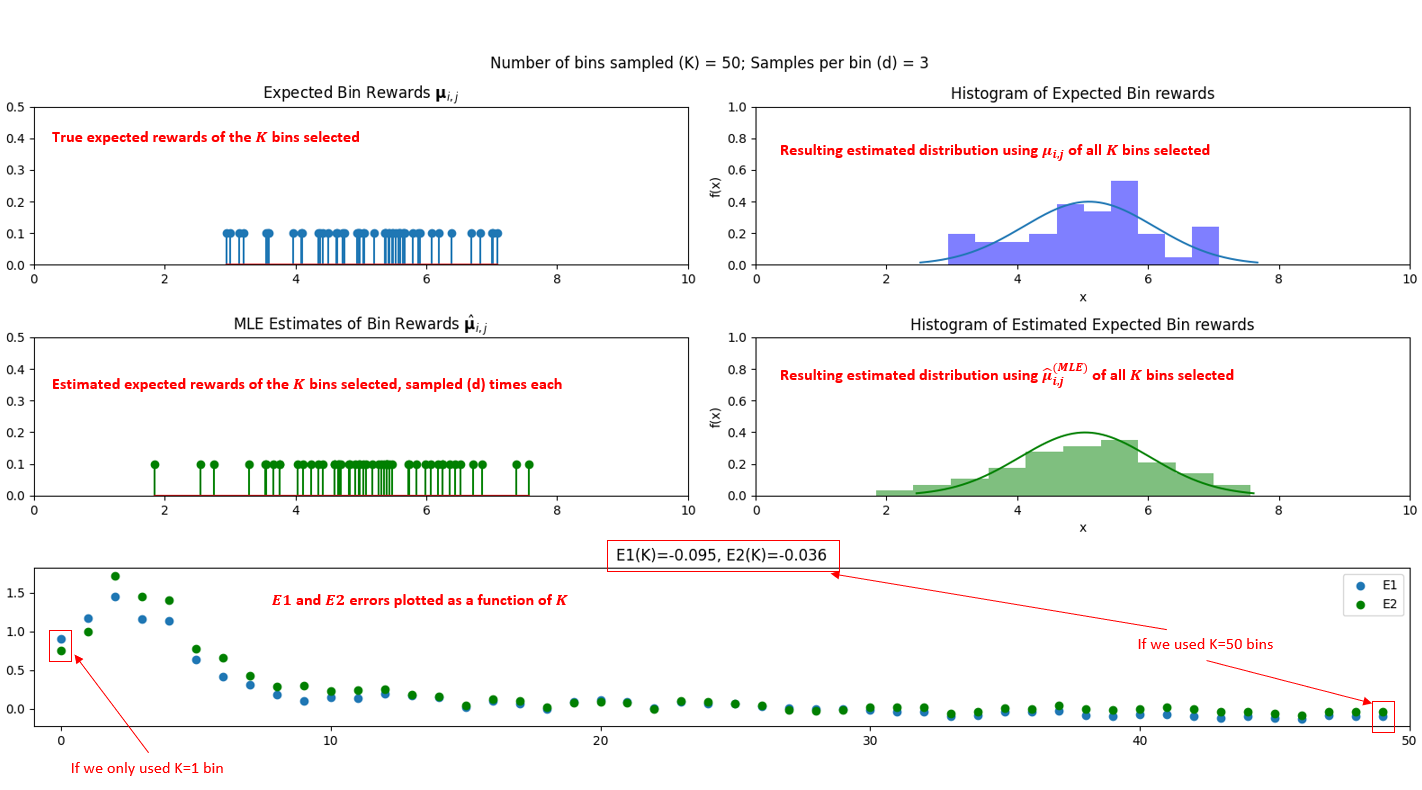


In [3]:
# Choose a bin, sample d times, form estimate (Repeat K times)
D = [1,3,5,10]

d = D[0]
K = 20

# Reward Histories (random)
r_hist = np.zeros([d, K])
r_avgs = np.zeros([K])
roll_avg = np.zeros([K])

# Actual Means (fixed)
act_roll_avg = np.zeros([K])

# Errors
E1 = np.zeros(K)
E2 = np.zeros(K)

for b in range(K):
    mu_ij = bin_means[b]
    r_hist[:d,b] = norm.rvs(loc = mu_ij, scale = sigma_ij, size= d)
    r_avgs[b] = np.mean(r_hist[:d,b])
    roll_avg[b] = moving_avg(r_avgs,b)
    act_roll_avg[b] = moving_avg(bin_means,b)
    E1[b] = samp_mu_i-act_roll_avg[b]
    E2[b] = samp_mu_i - roll_avg[b]
    


#### First plotting using only a single $K_i$ value

In [4]:
# Plots for using all K samples
plot_est_bins2(bin_means[:K], r_avgs, E1, E2, d = 3)

<IPython.core.display.Javascript object>

(<Figure size 1600x800 with 5 Axes>,
 {'a': <AxesSubplot:label='a', title={'center':'Expected Bin Rewards $\\mathbf{\\mu}_{i,j}$'}>,
  'b': <AxesSubplot:label='b', title={'center':'Histogram of Expected Bin rewards'}, xlabel='x', ylabel='f(x)'>,
  'c': <AxesSubplot:label='c', title={'center':'MLE Estimates of Bin Rewards $\\hat{\\mathbf{\\mu}}_{i,j}$'}>,
  'd': <AxesSubplot:label='d', title={'center':'Histogram of Estimated Expected Bin rewards'}, xlabel='x', ylabel='f(x)'>,
  'e': <AxesSubplot:label='e', title={'center':'E1(K)=-0.139, E2(K)=0.3'}, ylabel='$K_i$'>})

## Now over multiple $K_i$'s 

In [5]:
plot_est_bins_an(bin_means[:K], r_avgs, E1, E2, d, skip = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\GitHub\HMAB\Hierarchical Bayesian Estimation\plot_utils.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axd = plt.subplot_mosaic([['a', 'b'],['c','d'],['e', 'e']])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
#plt.close('all')

<span style="font-size:1.5em;">

#### Observations
Not sampling each bin enough times leads to poor estimates of $\mu_{i,j}$ and can result in high E2 Error

Sometimes a bad estimate of $\hat{\mu}_{i,j}$ can result in a better estimate of $\hat{\mu}_{i}$ when $K_i$ is low

However, a bad estimate of $\mu_{i,j}$ can also result in a worst estimate of $\hat{\mu}_{i}$




<span style="font-size:1.5em;">



# Stastistically Characterizing E2

Define the random vector $\mathbf{R}_{i,1}$ to be a vector of $K_{i,1}$ i.i.d random variables representing the random rewards from sampling bin $b_{i,1}$ $$\mathbf{R}_{i,1}=[R_{i,1}[1], R_{i,1}[2], ..., R_{i,1}[K_{i,1}]$$

Similarly, $\mathbf{R}_i$ is a random vector of the $K_{i}$ random vectors 
$$\mathbf{R}_{i}=[\mathbf{R}_{i,1}, \mathbf{R}_{i,2}, ..., \mathbf{R}_{i,K_i}]$$

We are interested in characterizing the error in our estimator $\hat{\mu}_i^{(MLE)}$ (i.e. E2), which is a function of $\mathbf{R}_i$ 

Let $\tilde{\mu}_{i,j}(K_{i,j})$ be the sample mean of $\mathbf{R}_{i,j}$:
$$\tilde{\mu}_{i,j}^{(MLE)}(K_{i,j}) = \frac{1}{K_{i,j}}\sum_{k=1}^{K_{i,j}}R_{i,j}[k]$$

which is a random variable itelf but not a random vector.

Similarly, let $\tilde{\mu}_{i}(K_{i},K_{i,j})$ be:

$$\tilde{\mu}_i^{(MLE)}(K_i, K_{i,j}) = \frac{1}{K_i}\sum_{j=1}^{K_i}\tilde{\mu}_{i,j}^{(MLE)}(K_{i,j})$$

Note: using tilde's to highlght the fact that these are random variables and not equivalent to the actual point estimates $\hat{\mu}_{i}$ or $\hat{\mu}_{i,j}$. Also using $(K_i)$ and $(K_{i,j})$ in their definition to reiterate that they functions of a number of other random variables. Going forward the ($K$'s) will be dropped from the notation
 
We are going to use these random variable to characterize the expectation and variance of E2 as a function of our problem parameters $\mu_i, \sigma_i, \sigma_{i,j}, K_i, K_{i,j}$  



## Simulations
We begin by simulating many different problem scenarios to empirically characterize the statistics of E2 over many different values of $K_{i,j}$ and $K_i$

What we are interested in is the average error and the variance of the error as a function of $K_i$ for $\hat{\mu}_i^{(MLE)}$ as well as for $K_{i,j} = d$

Below runs $M=1000$ simulations that produces a new sample of $\mathbf{b}_i^{(s)}$ during each interation, and repeats this for multiple values of $d$.  For each simulation it computes $\hat{\mu}_i^{(MLE)}$ for each value of $K_i = 1,2,..., 50$

(will take a minute to run)

In [7]:
# For Resetting Band/Bin parameters if needed

## Band Random Variable Setup
mu_i = 5 # Mean of the band generative distribution
sigma_i = 2 #Standard deviation of the band generative distribution
Band = norm(mu_i, sigma_i)

## Generating Bins
bin_means = Band.rvs(1000)
sigma_ij = 2 # standard deviation for all bin reward distributions
samp_mu_i = np.mean(bin_means)
samp_sigma_i = np.std(bin_means)
print(f"Expectation of the sample expected reward distribution = {round(samp_mu_i, 4)}")
print(f"Variance of the sample expected reward distribution = {round(samp_sigma_i, 4)}")

plot_env(Band,bin_means)

Expectation of the sample expected reward distribution = 4.927
Variance of the sample expected reward distribution = 1.9493


<IPython.core.display.Javascript object>

In [ ]:
# Repeating the above process
D = [1, 3, 5, 7]
K = 50
M = 1000



d_len = D.__len__()

i =0
Var_E2 = np.zeros([d_len,K])
Mean_E2 = np.zeros([d_len,K])

for d in D:
    E1 = np.zeros([M,K])
    E2 = np.zeros([M,K])
    for m in range(M):
        
    # Reward Histories (random)
        r_hist = np.zeros([d, K])
        r_avgs = np.zeros([K])
        roll_avg = np.zeros([K])
        # Actual Means (fixed)
        act_roll_avg = np.zeros([K])
        for b in range(K):
            mu_ij = bin_means[b]
            r_hist[:d,b] = norm.rvs(loc = mu_ij, scale = sigma_ij, size= d)
            r_avgs[b] = np.mean(r_hist[:d,b])
            roll_avg[b] = moving_avg(r_avgs,b)
            act_roll_avg[b] = moving_avg(bin_means,b)
            E1[m,b] = abs(samp_mu_i-act_roll_avg[b])
            E2[m,b] = abs(samp_mu_i - roll_avg[b])
            
    Var_E2[i,:] = np.var(E2, axis = 0)
    Mean_E2[i,:] = np.mean(E2, axis =0)
    i+=1


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,K+1),Mean_E2.T, label = D)
ax.set_title(f"E[E2] as a function of $K_i$ and $K_{{i,j}}$")
ax.set_xlabel("$K_i$")
ax.legend(title = f"$\K_{{i,j}}$")

In [ ]:
fig, ax = plt.subplots()
ax.plot(Var_E2.T, label = D)
ax.set_title(f"Var(E2) as a function of $K_i$ and $K_{{ij}}$")
ax.set_xlabel("$K_i$")
ax.legend(title = f"$\K_{{i,j}}$")

<span style="font-size:1.5em;">

## Characterizing the variance of our estimators


<span style="font-size:1.5em;">


### **What is the Distribution of** $R_{i,j}$**?**

In specifying the distribution for random reward distribution, we have always conditioned on knowing $\mu_{i,j}$:
$$R_{i,j}|\mu_{i,j}\sim N(\mu_{i,j},\sigma_{i,j}^2)$$

Conditioning on $\mu_{i,j}$ is the same as saying we have selected a bin $b_{i,j}$ and we know its distribution

However, in the context of our estimation process, this is not the case. We may know the bin we have selected, but we do not have knowledge about its distribution. 

Letting $\tilde{\mu}_{i,j}$ be a random variable denoting the expected value of randomly sampled bin $b_{i,j}$'s reward distribution (and using a slight abuse of notation) we can write the distribution of $R_{i,j}$ as:
$$R_{i,j} \sim N(\tilde{\mu}_{i,j},\sigma_{i,j}^2)$$

This is not an actual distribution because its parameterized by a random variable, but we can rewrite $R_{i,j}$ as:
$$R_{i,j} = \tilde{\mu}_{i,j} + W_{i,j}$$ 
where $W_{i,j}\sim N(0,\sigma_{i,j}^2)$ 

<span style="font-size:1.5em;">


#### Comment on $\tilde{\mu}_{i,j}$ vs $\mu_{i,j}$
$\tilde{\mu}_{i,j}$ is a random variable representing the distribution over all possible expected bin rewards, while $\mu_{i,j}$ is a realization of this random variable.  


<span style="font-size:1.5em;">



### $R_{i,j}$ as a function of Band Parameters
Now we are hoping to characterize the bin reward distribution as a function of the band distribution. To put $R_{i,j}$ as a function of Band $i$'s parameters we condition on $\mu_i$. 

*Note: We don't need to condition on the Band's scale parameter $\sigma_{i}$ because this known  i.e. not a random variable.*

According to our generative model we know the distribution of $\tilde{\mu}_{i,j}$ conditioned on $\mu_i$:
$$\tilde{\mu}_{i,j}|\mu_{i}\sim N(\mu_{i,}\sigma_i^2)$$

We can also rewrite the conditional distribution as:

$$\tilde{\mu}_{i,j}|\mu_{i} = \mu_i + W_i$$

where $W_i \sim N(0,\sigma_i^2)$

Now to express the random reward $R_{i,j}$ as a function of our band parameter $\mu_i$ and known distributions (i.e. are only functions of known parameters $\sigma_i$ and $\sigma_{i,j}$, we condition on $\mu_i$

$$R_{i,j}|\mu_{i}=\tilde{\mu}_{i,j}|\mu_i + Y_{i,j}|\mu_i = \mu_i+Y_i+Y_{i,j} $$

where $Y_{i,j}|\mu_i = Y_{i,j}$ because the bin reward variance is not dependent on the band (and its assumed known)

It follows that the conditional distribution is:
$$R_{i,j}|\mu_i \sim N(\mu_i, \sigma_i^2 + \sigma_{i,j}^2)$$

Which is different from the conditional distribution based on knowing $\mu_{i,j}$
$$R_{i,j}|\mu_{i,j} \sim N(\mu_{i,j}, \sigma_{i,j}^2)$$


<span style="font-size:1.5em;">

## Distribution of our MLE Estimators

Our end goal is to characterize the estimator:
$$\tilde{\mu}_{i}^{(MLE)} = \frac{1}{K_{i}} \sum_{j=1}^{K_i}\tilde{\mu}_{i,j}^{(MLE)}$$

Lets start by characterizing $\tilde{\mu}_{i,j}^{(MLE)}$ as a function of the band parameter $\mu_i$ which we do through conditioning as above:
 $$\tilde{\mu}_{i,j}^{(MLE)}|\mu_{i} = \frac{1}{K_{i,j}}\sum_{k=1}^{K_{i,j}}R_{i,j}|\mu_{i}[k] =\frac{1}{K_{i,j}}\sum_{k=1}^{K_{i,j}}\mu_i+Y_i+Y_{i,j} $$

Which is simply the average of $K_{i,j}$ i.i.d conditional random variables. Since the conditional random variables are i.i.d according to $N(\mu_{i}, \sigma_i^2 + \sigma_{i,j}^)$, we can use the fact that they are normally distributed with know parameters to express the distribution of this average as:
$$\tilde{\mu}_{i,j}^{(MLE)}|\mu_{i} \sim N\left(\mu_i,\frac{\sigma_i^2 + \sigma_{i,j}^2}{K_{i,j}}\right)$$

We can use the same process to then define the distribution of $\tilde{\mu}_{i}^{(MLE)}$ conditioned on $\mu_i$:

$$\begin{align}\tilde{\mu}_{i}^{(MLE)}|\mu_{i} &= \frac{1}{K_i}\sum_{k=1}^{K_i}\tilde{\mu}_{i,k}^{(MLE)}|\mu_{i} \\ & \sim N\left(\mu_i,\frac{\sigma_i^2 + \sigma_{i,j}^2}{K_i K_{i,j}} \right)\end{align}$$

Note: The above assumes $\sigma_{i,j}$ and $K_{i,j}$ is the same for all bins. If this is not the case then the above is:

$$\tilde{\mu}_{i}^{(MLE)}|\mu_{i} =\frac{1}{K_i}\sum_{j=1}^{K_i}\left(\frac{1}{K_{i,j}}\sum_{l=1}^{K_{i,j}}\mu_i+Y_i+Y_{i,j}\right) \sim N\left(\mu_i, \frac{1}{K_i}\sum_{j=1}^{K_i}\frac{\sigma_i^2 + \sigma_{i,j}^2}{K_{i,j}}\right)$$




## Plotting as a function of $\sigma_{i,j}$
The following plots the variance of $\tilde{\mu}_i^{(MLE)}$ as a function of different $\sigma_{i,j}$ (common for all $b_{i,j}$) for a fixed $K_{i,j}$


In [ ]:
Sigma = [1,2,3]
s_len = Sigma.__len__()

X = np.zeros([s_len, K])

for s in range(s_len):
    for k in range(K):
        X[s,k] = (sigma_i^2 + Sigma[s]^2)/(d*(k+1))
        
fig, ax = plt.subplots()
ax.plot(X.T, label = Sigma)
ax.set_title(f"Var($\\tilde{{\mu}}_i^{{(MLE)}}$) as a function of $K_i$ and $\sigma_{{i,j}}$")
ax.set_xlabel("$K_i$")
ax.legend(title = f"$\sigma_{{i,j}}$")


<span style="font-size:1.5em;">

# Resimulate using different variances:

The same process as above is repeated, this time using difference $\sigma_{i,j}$ values


In [ ]:
d = 3
K = 100
M = 1000

## Band Random Variable Setup
mu_i = 5 # Mean of the band generative distribution
sigma_i = 2 #Standard deviation of the band generative distribution
Band = norm(mu_i, sigma_i)


Sigma = [1,2,3]
s_len = Sigma.__len__()

i =0
Var = np.zeros([s_len,K])
Mean = np.zeros([s_len,K])
Mean_E2 = np.zeros([s_len,K])

for s in Sigma:
 
    ## Generating Bins
    bin_means = Band.rvs(1000)
    sigma_ij = s # standard deviation for all bin reward distributions
    samp_mu_i = np.mean(bin_means)
    est_mu = np.zeros([M,K])
    E2 = np.zeros([M,K])

    #samp_sigma_i = np.std(bin_means) # not used in this
    for m in range(M):
    # Reward Histories (random)
        r_hist = np.zeros([d, K])
        r_avgs = np.zeros([K])
        roll_avg = np.zeros([K])
        # Actual Means (fixed)
        act_roll_avg = np.zeros([K])
        for b in range(K):
            mu_ij = bin_means[b]
            r_hist[:d,b] = norm.rvs(loc = mu_ij, scale = sigma_ij, size= d)
            r_avgs[b] = np.mean(r_hist[:d,b])
            roll_avg[b] = moving_avg(r_avgs,b)
            est_mu[m,b] = roll_avg[b]
            E2[m,b] = samp_mu_i - est_mu[m,b]
            
            
            
    Var[i,:] = np.var(est_mu, axis = 0)
    Mean[i,:] = np.mean(est_mu, axis =0)
    Mean_E2[i,:] = np.mean(E2,axis = 0)
    i+=1


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,K+1),Mean_E2.T, label = Sigma)
ax.set_title(f"E[E2] as a function of $K_i$ and $\sigma_{{i,j}}$")
ax.set_xlabel("$K_i$")
#ax.set_xticks(range(1,K+1))
ax.legend(title = f"$\sigma_{{i,j}}$")

In [ ]:
fig, ax = plt.subplots()
ax.plot(Var.T, label = Sigma)
ax.set_title(f"Var(E2) as a function of $K_i$ and $\sigma_{{i,j}}$")
ax.set_xlabel("$K_i$")
ax.legend(title = f"$\sigma_{{i,j}}$")

<span style="font-size:1.5em;">


# Discussion

Thus the MLE estimator $\hat{\mu}_i^{(MLE)}$ suffers from potentially very high variance as $\sigma_i$ or $\sigma_{i,j}$ increases

Additionally, it suffers from the "cold-start" problem meaning that the initial estimates are heavily biased towards the first samples.  This is a problem when the variance of the initial samples is high (as could be the case in our model)

<span style="font-size:1.5em;">


# Next Steps

Bayesian estimation provides three main benefits:
    
1. Reduction in the variance of the band estimator in the early stages
    
    
2. Reduction of the variance of the bin estimator
   

## Hierarichal Bayesian Estimation
Specify a prior on $\mu_i$ i.e. $P(\mu_i) = N(\mu^*, \sigma^*)$
Estimation model:
$$R_{i,j}|\mu_{i,j} \sim N(\mu_{i,j}, \sigma_{i,j}^2)$$
$$\mu_{i,j}|\mu_i \sim N(\mu_i,\sigma_i^2)$$
$$\mu_i \sim N(\mu^*, \sigma^{*2})$$

### Full Hierarchical Bayesian Estimation
After observing reward $r_{i,j}$, update according to:
$$\begin{align}P(\mu_i|r_{i,j}) &\propto P(r_{i,j}|\mu_i)P(\mu_i) \\
&\propto 
\end{align}$$
where we know $P(r_{i,j}|\mu_i) \sim N(\mu_i\,\sigma_i^2 + \sigma_{i,j}^2)$ and $P(\mu_i)\sim N(\mu^*, \sigma^{*2})$ 
Thus: 
$$P(\mu_i|r_{i,j} \sim N(\frac{(\sigma_i^2 + \sigma_{i,j}^2\mu^*) + \sigma^{*2}(\mu_i-r_{ij})}{\sigma_{i,j}^2 + \sigma_i^2 + \sigma^{*2}}, \frac{1}{\frac{1}{\sigma_{i,j}^2 + \sigma_i^2} + \frac{1}{\sigma^{2*}}})$$

Note: closed form only avaiabl when we have conditional conjugancy for hyperprior distribution $P(\mu_i)$ and second-level (or instance prior) $P(\mu_{i,j}|\mu_i)$

### Empirical Hierarchical Bayesian Estimation
This is what we used before, where instead of computing $P(\mu_i|r_{i,j})$ as in the Full Hierarchical Bayesian Estimation scenario, we compute a point estimate of $\hat{\mu}_{i,j}$ using $r_{i,j}$ and then compute $P(\mu_i|\hat{\mu}_{i,j})$



